In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import tkp.db
import tkp.config
import logging
import csv
import time
import sys
import glob
import itertools


import healpy as hp
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import os

from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.wcs import WCS

import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

import pylab

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata


In [3]:
def dump_trans(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    # find all the new, candidate transient, sources detected by the pipeline
    transients_query = """
    SELECT  tr.runcat
           ,tr.newsource_type
           ,im.rms_min
           ,im.rms_max
           ,im.detection_thresh
           ,ex.f_int
    FROM newsource tr
         ,image im
         ,extractedsource ex
    WHERE tr.previous_limits_image = im.id
      AND tr.trigger_xtrsrc = ex.id
    """
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients

def dump_sources(dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    # extract the properties and variability parameters for all the running catalogue sources in the dataset
    sources_query = """\
    SELECT  im.taustart_ts
            ,im.tau_time
            ,ex.f_int
            ,ex.f_int_err
            ,ex.f_peak
            ,ex.f_peak_err
            ,ax.xtrsrc
            ,ex.extract_type
            ,ex.det_sigma
            ,ax.runcat as runcatid
            ,ex.ra
            ,ex.decl
            ,ex.ra_err
            ,ex.decl_err
            ,im.band
            ,im.rms_min
            ,im.rms_max
            ,ax.v_int
            ,ax.eta_int
            ,ax.f_datapoints
            ,im.freq_eff
            ,im.url
    FROM extractedsource ex
         ,assocxtrsource ax
         ,image im
         ,runningcatalog rc
    WHERE ax.runcat = rc.id
      AND ax.xtrsrc = ex.id
      and ex.image = im.id
      AND rc.dataset = %s
      ORDER BY rc.id
    """
    cursor = tkp.db.execute(sources_query, (dataset_id,))
    sources = tkp.db.generic.get_db_rows_as_dicts(cursor)

    print "Found", len(sources), "source datapoints"

    return sources 

In [4]:
def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [5]:
def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df.sort_index()


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    # plt.title("Source: N = {}".format(len(source_df["f_int"].values[np.isfinite(source_df["f_int"])])))
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    # plt.ylabel("Normalized N")
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure
#     plt.show()
# fig.text(0.5, 0.04, 'date', ha='center')
# plt.tight_layout()
# print(source_df["wm_ra"].values[0],source_df["wm_decl"].values[1])
# plt.savefig("{}_multiday_lightcurve.png".format(key))



In [6]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

In [7]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
# database = 'raw_16SB'
# database = 'flux_16SB'
# database = 'fluxcal_db'

# databases = ['higher_201702250130','lower_201702250130']
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

In [ ]:

transients_query = """SELECT taustart_ts 
    FROM image 
    WHERE taustart_ts 
    BETWEEN  '2019-01-27 09:36:56' AND  '2019-01-27 10:36:56'"""


transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
    FROM extractedsource ex 
    WHERE ex.image = (SELECT id FROM image 
    WHERE taustart_ts = '{}' AND band = {});""".format(GP_df.iloc[j].taustart_ts.strip(),
                                                        GP_df.iloc[j].band)

In [ ]:
survey_stats = pd.read_csv("/home/kuiack/survey_stats.csv")

# TODO 

- (b) Get Obs time span 
- (b) loop over X min chuncks of database  
    - ( ) (parallel?) look for new source in interval which satisfy candidate criteria 
    
    
- ( ) Make inspection figure of candidate 


In [14]:
vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", comment="#", delimiter="\t")
# tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),
         "decl":np.array([21.98,40.59,58.54,12.66])}


**Get obs time span**

In [9]:
# get beginning and end time

AS_db = "ASr_201609051647"
dataset = 1 

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    (SELECT taustart_ts 
    FROM image ORDER BY taustart_ts ASC LIMIT 30)
    UNION ALL
    (SELECT taustart_ts 
    FROM image ORDER BY taustart_ts DESC LIMIT 30)
    """

time_range = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                                          engine, host, port, user, password))

db._configured = False
del db, session

time_intervals = pd.date_range(start= np.min(time_range[np.abs(time_range.diff(periods= -10)
                                                               .astype('timedelta64[s]')) < 15.]
                                             .taustart_ts),
                               end= np.max(time_range[np.abs(time_range.diff(periods= -10)
                                                             .astype('timedelta64[s]')) < 15.]
                                           .taustart_ts)+datetime.timedelta(minutes=9),
                               freq="10min")


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASr_201609051647
INFO:tkp.db.database:connecting to database...


In [24]:
# AS_db = "ASr_201609051647"
dataset = 1

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

for t1, t2 in zip(time_intervals[:-1],time_intervals[2:3]):
    time_1 = time.time()
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()


# Works, but is slow.
    transients_query = """
        SELECT  im.taustart_ts
                ,im.freq_eff
                ,im.band
                ,im.rms_min
                ,im.rms_max
                ,im.url
                ,ex.f_int
                ,ex.f_int_err
                ,ex.f_peak
                ,ex.f_peak_err
                ,ex.ra
                ,ex.decl
                ,ex.ra_err
                ,ex.decl_err
                ,ex.extract_type
                ,ex.det_sigma
                ,ax.runcat as runcatid
                ,ax.v_int
                ,ax.eta_int
                ,ax.f_datapoints
        FROM extractedsource ex
             ,assocxtrsource ax
             ,image im
             ,runningcatalog rc
        WHERE ax.runcat = rc.id 
           AND ax.xtrsrc = ex.id
           AND ex.image = im.id
           AND rc.id IN
        (SELECT DISTINCT ns.runcat 
        FROM image im, newsource ns 
        WHERE ns.trigger_xtrsrc 
        IN (SELECT ex.id 
            FROM extractedsource ex, image im 
            WHERE ex.image = im.id 
            AND im.taustart_ts 
            BETWEEN '{}' AND '{}'))""".format(t1, t2)

    transients = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                              engine, host, port, user, password))
    
    transients = transients[transients.rms_max < 3e2]
    
    db._configured = False
    del db, session

    print time.time() - time_1
    

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASr_201609051647
INFO:tkp.db.database:connecting to database...


29.9894721508


In [25]:
# Reduce with conditions requireing simultaneous 5sigma and one 8sigma detection
time_1 = time.time()

N_detections = 0 

reduced = pd.DataFrame([])


transients["round_times"] = transients.taustart_ts.dt.round("1s")


for _id in np.unique(transients.runcatid):
    if (np.min(transients[(transients.runcatid == _id) & \
                         (transients.band == 24) & \
                         (transients.extract_type == 0)].round_times) < \
    np.min(transients[(transients.runcatid == _id) & \
                      (transients.band == 23) & \
                      (transients.extract_type == 0)].round_times) \
#     and (np.max(transients[(transients.runcatid == _id )].det_sigma) > 8 ):
    or

# for _id in np.unique(transients.runcatid):
    len(transients[(transients.runcatid == _id) & \
                (transients.band == 23) & \
                (transients.extract_type == 0)].set_index("round_times").index.\
           intersection(transients[(transients.runcatid == _id) & \
                             (transients.band == 24) & \
                             (transients.extract_type == 0)].set_index("round_times").index )) > N_detections) \
    and (np.max(transients[(transients.runcatid == _id )].det_sigma) > 8 ):

        if len(reduced) == 0:
            reduced = pd.DataFrame(transients[(transients.runcatid == _id)])
        else:
            reduced = pd.concat([reduced, transients[(transients.runcatid == _id)]])

print time.time() - time_1



24.2518360615


In [26]:
base = reduced.groupby("runcatid").median()
base["taustart_ts"] = reduced.groupby("runcatid").first().taustart_ts
base["timestep"] = [x.timestamp() for x in base.taustart_ts]

In [34]:
base.loc[43]

band                             23
decl                        38.5584
decl_err                   0.169098
det_sigma                   4.24012
eta_int                    0.390083
extract_type                      1
f_datapoints                  385.5
f_int                       12.1593
f_int_err                   6.06304
f_peak                      11.3018
f_peak_err                  3.10916
freq_eff                5.83705e+07
ra                           256.39
ra_err                     0.216894
rms_max                     28.9339
rms_min                     2.48906
v_int                      0.310328
taustart_ts     2016-09-05 16:47:13
timestep                1.47309e+09
Name: 43, dtype: object

In [35]:
time_1 = time.time()

aart_coord = SkyCoord(aart.ra.values*u.deg, aart.decl.values*u.deg, frame='fk5')
ateam_coord = SkyCoord(ateam["ra"]*u.deg, ateam["decl"]*u.deg, frame='fk5')

filtered = pd.DataFrame([], columns=base.keys())
AART_catsource = pd.DataFrame([], columns=base.keys())


for i in base.index:
    try:
        c1 = SkyCoord(base.loc[i].ra*u.deg, base.loc[i].decl*u.deg, frame='fk5')

        c2 = SkyCoord(base.drop(index=i).ra.values*u.deg, 
                  base.drop(index=i).decl.values*u.deg, frame='fk5')
    except IndexError:
        print i
    if np.min(c1.separation(ateam_coord).deg) < 10:
        continue 
        
    elif np.min(c1.separation(aart_coord).deg) < 3 and base.loc[i].f_datapoints.astype(float) > 10:
        if len(AART_catsource) == 0:
            AART_catsource = pd.DataFrame(base.loc[i]).T
        else:
            AART_catsource = pd.concat([AART_catsource, pd.DataFrame(base.loc[i]).T])
 

    elif np.logical_or(((c1.separation(c2).deg) > 5),
                       (np.abs(base.loc[i].timestep - base.drop(index=i).timestep) > 500)).all():
        if len(filtered) == 0:
            filtered = pd.DataFrame(base.loc[i]).T
        else:
            filtered = pd.concat([filtered, pd.DataFrame(base.loc[i]).T])

print time.time() - time_1

0.915555000305


In [28]:
print len(np.unique(transients.runcatid))
print len(np.unique(reduced.runcatid))
print len(filtered)

720
49
4


In [38]:
retrieve_source(transients, 43)

band       decl  decl_err  det_sigma   eta_int  \
taustart_ts                                                           
2016-09-05 16:47:13    23  38.534370  0.123056   5.026501  0.000000   
2016-09-05 16:47:14    23  38.534370  0.154568   3.987465  0.130198   
2016-09-05 16:47:14    24  38.534370  0.515327   2.351926  0.000000   
2016-09-05 16:47:15    23  38.534370  0.450776   4.171624  0.268046   
2016-09-05 16:47:15    24  38.534370  0.357085   2.343036  0.050357   
2016-09-05 16:47:16    24  38.534370  0.356825   2.430372  0.033108   
2016-09-05 16:47:17    24  38.534370  0.291169   2.431500  0.038175   
2016-09-05 16:47:18    23  38.534370  0.154939   4.215180  0.188948   
2016-09-05 16:47:18    24  38.534370  0.310232   2.805386  0.031712   
2016-09-05 16:47:19    23  38.534370  0.162171   4.378068  0.217715   
2016-09-05 16:47:19    24  38.534370  0.417017   2.520563  0.031092   
2016-09-05 16:48:08    23  38.470734  0.118385   5.011604  0.236388   
2016-09-05 16:48:08    24  38.501300  0.449394   2.568329  0.032296   
2016-09-05 16:48:09    23  38.501300  0.167593   4.493841  0.211448   
2016-09-05 16:48:09    24  38.501300  0.258303   3.210938  0.044272   
2016-09-05 16:48:10    23  38.501300  0.191821   3.455066  0.204880   
2016-09-05 16:48:10    24  38.501300  0.278640   2.688059  0.049151   
2016-09-05 16:48:11    23  38.501300  0.172650   4.043620  0.187487   
2016-09-05 16:48:11    24  38.501300  0.248519   3.110856  0.054177   
2016-09-05 16:48:12    23  38.501300  0.192929   3.330575  0.168690   
2016-09-05 16:48:12    24  38.501300  0.310298   2.381344  0.049023   
2016-09-05 16:48:13    23  38.501300  0.177152   4.010565  0.153573   
2016-09-05 16:48:23    23  38.421035  0.120620   5.026861  0.145720   
2016-09-05 16:48:23    24  38.474515  0.383427   2.303662  0.047807   
2016-09-05 16:48:24    23  38.474515  0.146179   4.632794  0.133802   
2016-09-05 16:48:24    24  38.474515  0.391276   2.354804  0.045686   
2016-09-05 16:48:25    23  38.474515  0.152419   4.474138  0.130070   
2016-09-05 16:48:25    24  38.474515  0.321522   2.458510  0.042173   
2016-09-05 16:48:26    23  38.474515  0.149221   4.583581  0.120841   
2016-09-05 16:48:26    24  38.474515  0.436394   2.256461  0.041609   
...                   ...        ...       ...        ...       ...   
2016-09-05 19:33:22    24  38.573115  0.206463   3.717017  0.618719   
2016-09-05 19:33:23    23  38.573115  0.304413   2.804350  0.444490   
2016-09-05 19:33:23    24  38.573115  0.205319   3.018289  0.617925   
2016-09-05 19:33:24    23  38.573115  0.315034   2.989390  0.446787   
2016-09-05 19:33:24    24  38.573115  0.226599   3.127381  0.617085   
2016-09-05 19:33:25    23  38.573115  0.393595   2.643187  0.448516   
2016-09-05 19:33:25    24  38.573115  0.230247   3.205748  0.616265   
2016-09-05 19:33:26    23  38.573115  0.446827   2.338233  0.453655   
2016-09-05 19:35:01    24  38.592148  0.115837   5.013339  0.617657   
2016-09-05 19:35:02    23  38.486968  0.110004   5.446078  0.453192   
2016-09-05 19:35:02    24  38.572952  0.149268   4.866584  0.617337   
2016-09-05 19:35:03    23  38.572952  0.152716   4.891841  0.452781   
2016-09-05 19:35:03    24  38.572952  0.160334   4.212974  0.617187   
2016-09-05 19:35:04    23  38.483080  0.116095   5.232150  0.452297   
2016-09-05 19:35:04    24  38.572763  0.153810   4.834540  0.616765   
2016-09-05 19:35:05    23  38.430608  0.099087   6.189425  0.452235   
2016-09-05 19:35:05    24  38.572353  0.151285   4.484416  0.616347   
2016-09-05 19:35:06    23  38.485823  0.105747   5.699336  0.451872   
2016-09-05 19:35:06    24  38.572134  0.164775   4.109970  0.615845   
2016-09-05 19:35:07    23  38.458252  0.114998   5.262674  0.451364   
2016-09-05 19:35:07    24  38.571891  0.238252   3.542113  0.615052   
2016-09-05 19:35:08    23  38.571891  0.164831   4.835878  0.451300   
2016-09-05 19:35:08    24  38.571891  0.197476   3.871518  0.614227   
2016-09-05 19:35:09    23  38.571891  0.17753

In [37]:
filtered.index

Int64Index([43, 85, 367, 540], dtype='int64')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Image files not on disk


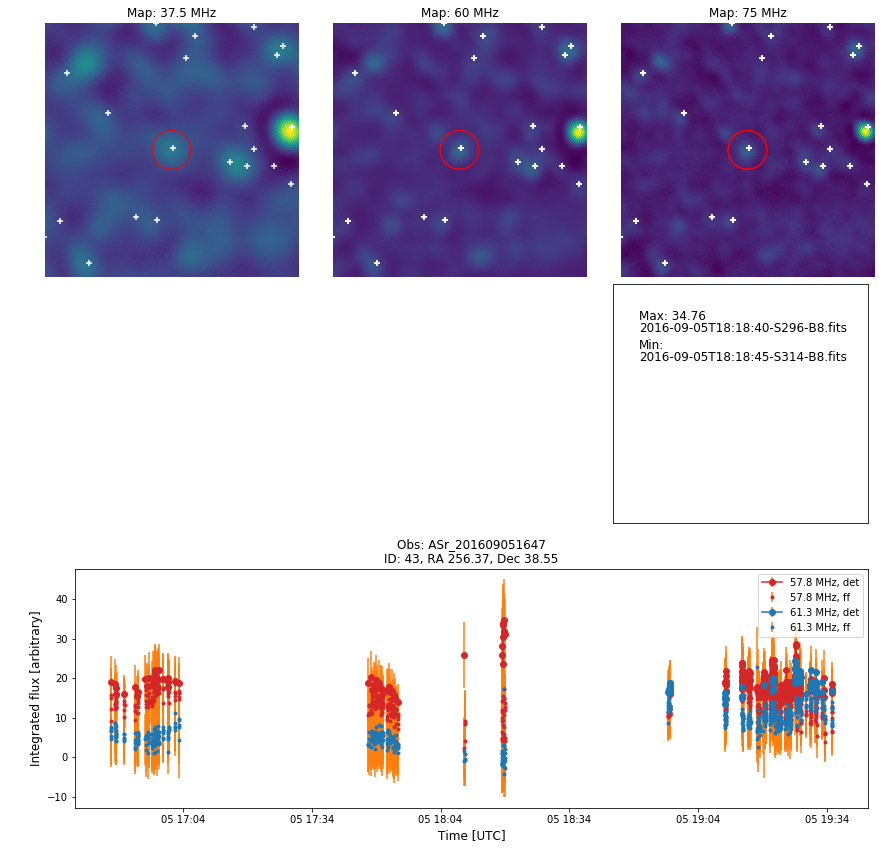

Image files not on disk


<Figure size 432x288 with 0 Axes>

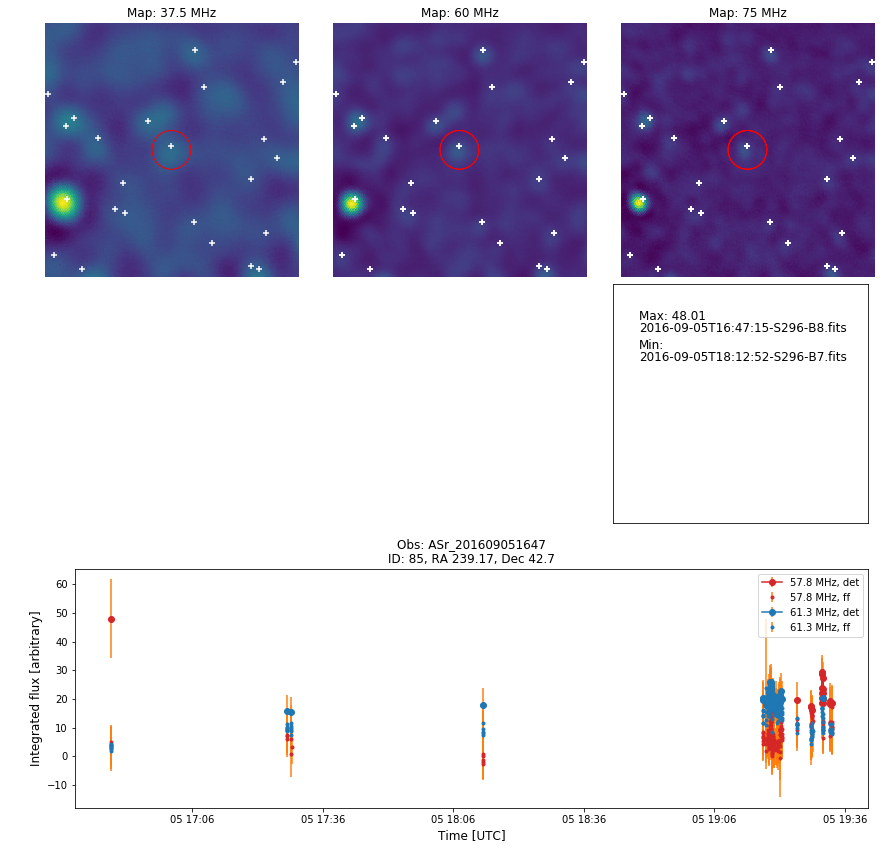

Image files not on disk


<Figure size 432x288 with 0 Axes>

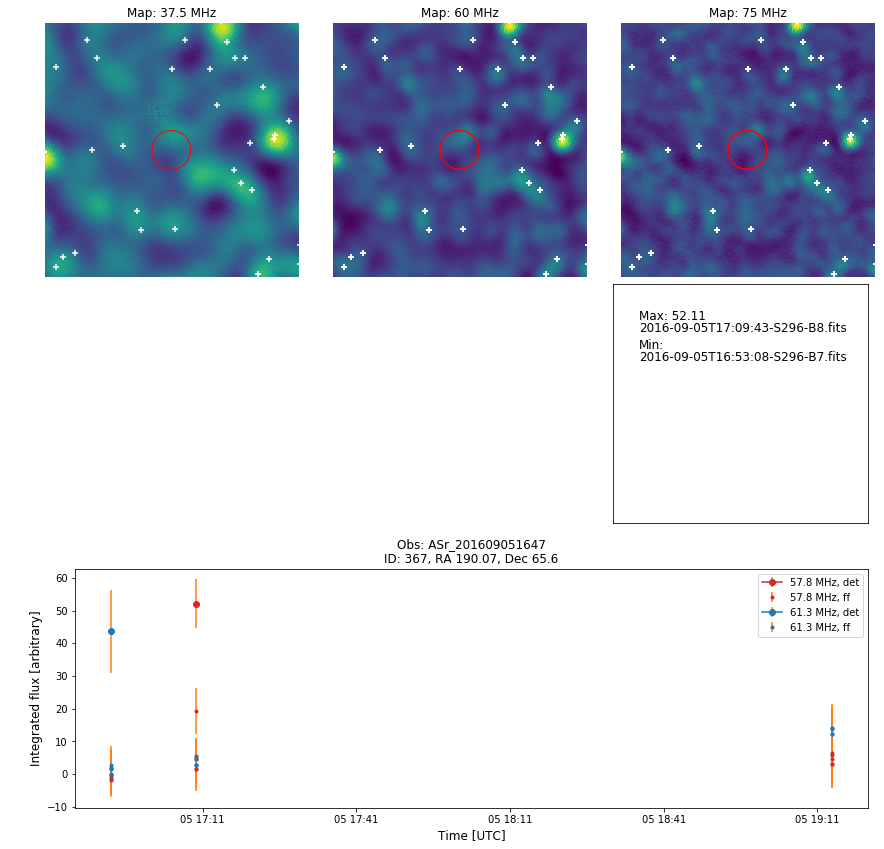

Image files not on disk


<Figure size 432x288 with 0 Axes>

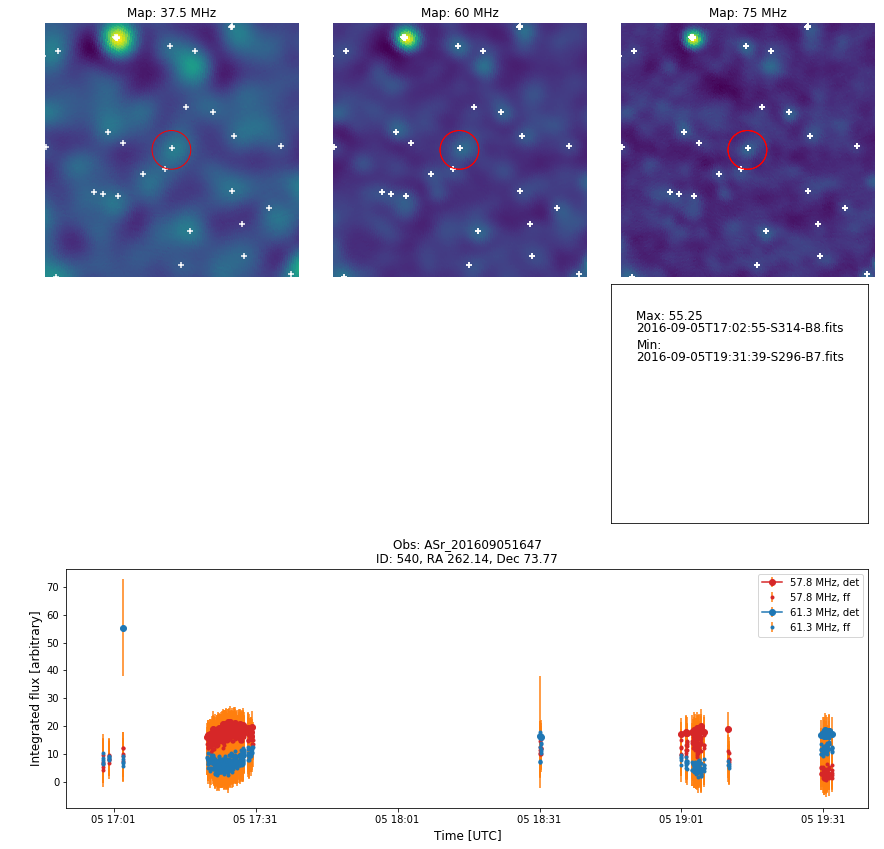

<Figure size 432x288 with 0 Axes>

In [19]:
# Make inspection plot

stamp_side = 600
half_side = int(stamp_side/2)
dbname = AS_db


x = np.linspace(0, stamp_side, stamp_side)
y = np.linspace(0, stamp_side, stamp_side)
x, y = np.meshgrid(x, y)

ObsDir = "/mnt/ads001/"+dbname+"_Candidates/"
map_dir = "/home/kuiack/skymaps/"
files = glob.glob(map_dir+"*.fits")
BANDS = [os.path.basename(i)[:4] for i in files]

delta = 100 
vlssr_thresh= 5




map_load_1 = hp.fitsfunc.read_map(map_dir+BANDS[2]+"_512_map.fits")
map_load_2 = hp.fitsfunc.read_map(map_dir+BANDS[3]+"_512_map.fits")

map_load_3 = hp.fitsfunc.read_map(map_dir+BANDS[18]+"_512_map.fits")


for _ID in filtered.index: #AART_catsource.index:

    source_df = retrieve_source(transients, _ID)

    _source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
    _index = source_df.extract_type[(source_df.freq_eff < 60000000) ].values
    _source_flux[(_index == 1)] = np.nan


    plt.figure(figsize=(12,12))
    
    stamp = hp.gnomview(map_load_1,  xsize=stamp_side,
                        rot=([base.loc[_ID].ra,
                              base.loc[_ID].decl]),
                        coord="C", return_projected_map=True,fig=fig_n,sub=333,notext=True, title="Map: 75 MHz",cbar=False)

    hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                   marker="+", color="white", coord="C")

    hp.projscatter(base.loc[_ID].ra,
                   base.loc[_ID].decl,lonlat=True,
                   edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)
#######
    stamp = hp.gnomview(map_load_3,  xsize=stamp_side,
                        rot=([base.loc[_ID].ra,
                              base.loc[_ID].decl]),
                        coord="C", return_projected_map=True, 
                        fig=fig_n,sub=332, notext=True, title="Map: 60 MHz", cbar=False)

    hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                   marker="+", color="white", coord="C")

    hp.projscatter(base.loc[_ID].ra,
                   base.loc[_ID].decl,lonlat=True,
                   edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)
    
########
    stamp = hp.gnomview(map_load_2, xsize=stamp_side,
                        rot=([base.loc[_ID].ra,
                              base.loc[_ID].decl]),
                        coord="C", return_projected_map=True, fig=1,sub=331, notext=True, title="Map: 37.5 MHz",cbar=False)


    hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                   marker="+", color="white", coord="C")

    hp.projscatter(base.loc[_ID].ra,
                   base.loc[_ID].decl,lonlat=True,
                   edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)

    plt.subplot(313)

    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
                 _source_flux, 
                 yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
                 fmt="o-", color="C3",ecolor="C1", label="57.8 MHz, det")

    del _source_flux

    if len(source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values) > 0:
        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                     source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
                     yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                     fmt=".", color="C3",ecolor="C1", label="57.8 MHz, ff")


    _source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
    _index = source_df.extract_type[(source_df.freq_eff > 60000000) ].values
    _source_flux[(_index == 1)] = np.nan


    plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
                 _source_flux, 
                 yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) ].values,
                 fmt="o-",color="C0", ecolor="C1", label="61.3 MHz, det")

    del _source_flux

    if len(source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values) > 0:
        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                     source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
                     yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                     fmt=".", color="C0",ecolor="C1", label="61.3 MHz, ff")


    plt.legend()
    plt.ylabel("Integrated flux [arbitrary]")
    plt.xlabel("Time [UTC]")

    plt.title("Obs: "+dbname+"\nID: "+str(_ID)+", RA "+str(round(source_df.ra.mean(),2))+", Dec "+str(round(source_df.decl.mean(),2)))
    
    try:
        
        if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.max()].url[0]):
            filename = source_df[ source_df.f_int == source_df.f_int.max()].url[0]
        else: 
            filename = "/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[3]
        

        wcs = WCS(filename)
        im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

        pos = [im_pix_x, im_pix_y]
        plt.subplot(3,3,4)
        plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
        plt.text(0.5,0.5,"max", color="white", fontsize=18)
        plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
        plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")

        plt.xticks([])
        plt.yticks([])

        plt.subplot(3,3,5)
        if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.min()].url[0]):
            filename = source_df[ source_df.f_int == source_df.f_int.min()].url[0]

        wcs = WCS(filename)
        im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

        pos = [im_pix_x, im_pix_y]

        plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
        plt.text(0.5,0.5,"min", color="white", fontsize=18)
        plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
        plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")
        plt.xticks([])
        plt.yticks([])
    except TypeError:
        print "Image files not on disk"
    
    
    ax = plt.subplot(3,3,6)
    plt.text(0.1,0.85,"Max: {}".format(round(source_df[ source_df.f_int == source_df.f_int.max()].f_int.values[0],2)), 
             color="black",transform=ax.transAxes,fontsize=12)
    
    plt.text(0.1, 0.80, os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0]), 
             color="black",transform=ax.transAxes, fontsize=12)

    plt.text(0.1, 0.68, os.path.basename(source_df[ source_df.f_int == source_df.f_int.min()].url[0]), 
             color="black",transform=ax.transAxes, fontsize=12)
    plt.text(0.1,0.73,"Min:", color="black",transform=ax.transAxes,fontsize=12)
    plt.plot()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()

    plt.show()
    if not os.path.exists(ObsDir):
        os.makedirs(ObsDir+"/CandidatePandas")

#     for _ID in filtered.index:
    source_df = retrieve_source(transients, _ID)
    plt.savefig(ObsDir+str(_ID)+"_lightcurve.png")
    source_df.to_csv(ObsDir+"/CandidatePandas/"+str(_ID)+"-source_df.csv", index=False)
    



In [184]:
os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0])

u'2016-09-05T19:01:10-S314-B8.fits'

In [164]:
x = source_df[ source_df.f_int == source_df.f_int.max()].taustart_ts.values[0]

In [169]:
datetime.datetime.strftime(pd.to_datetime(source_df[ source_df.f_int == source_df.f_int.max()].taustart_ts.values[0]),
                          "%y-%m-%dT%H:%M:%S")

'16-09-05T19:01:10'

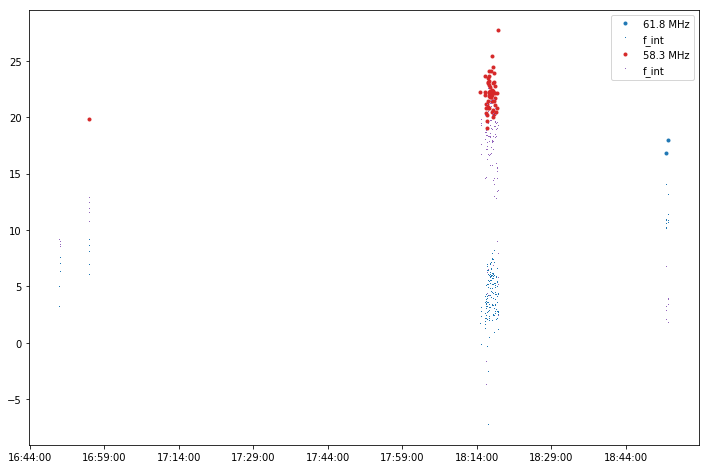

In [51]:
_id = 176

_index = (transients.runcatid == _id) & (transients.rms_max < 1e2) & (transients.freq_eff > 60000000)
_index  = np.abs(transients[_index  ]
       .taustart_ts.diff(periods= -1)
       .astype('timedelta64[s]')) < 1e5


plt.figure(figsize=(12,8))
ax = plt.subplot(111)

plt.plot(transients[_index & (transients.extract_type == 0 ) ].taustart_ts,
         transients[_index & (transients.extract_type == 0 )].f_int, ".", c="C0", label="61.8 MHz")
plt.plot(transients[_index & (transients.extract_type == 1 ) ].taustart_ts,
         transients[_index & (transients.extract_type == 1 )].f_int, ",",c="C0", label=None)

_index = (transients.runcatid == _id) & (transients.rms_max < 1e4) & (transients.freq_eff < 60000000)

_index  = np.abs(transients[_index  ]
       .taustart_ts.diff(periods= -1)
       .astype('timedelta64[s]')) < 1e5

plt.plot(transients[_index &(transients.extract_type == 0 )].taustart_ts,
         transients[_index & (transients.extract_type == 0 )].f_int, ".",c="C3", label="58.3 MHz")
plt.plot(transients[_index & (transients.extract_type == 1 )].taustart_ts,
         transients[_index & (transients.extract_type == 1 )].f_int, ",", c="C4", label=None)

myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
plt.legend()

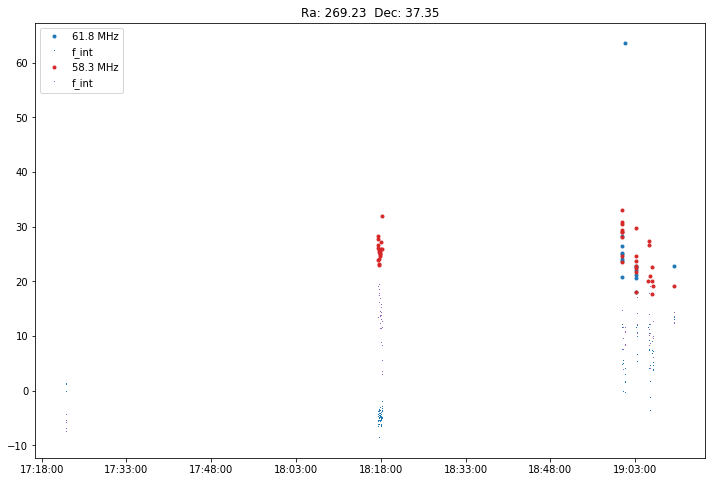

In [208]:
_id = 1217

_index = (transients.runcatid == _id) & (transients.freq_eff > 60000000)
_index  = np.abs(transients[_index  ]
       .taustart_ts.diff(periods= -1)
       .astype('timedelta64[s]')) < 1e5


plt.figure(figsize=(12,8))
ax = plt.subplot(111)

plt.title("Ra: "+str(round(filtered[filtered.index == _id].ra,2))+"  "+\
          "Dec: "+str(round(filtered[filtered.index == _id].decl,2)),)

plt.plot(transients[_index & (transients.extract_type == 0 ) ].taustart_ts,
         transients[_index & (transients.extract_type == 0 )].f_int, ".", c="C0", label="61.8 MHz")
plt.plot(transients[_index & (transients.extract_type == 1 ) ].taustart_ts,
         transients[_index & (transients.extract_type == 1 )].f_int, ",",c="C0", label=None)

_index = (transients.runcatid == _id) & (transients.freq_eff < 60000000)

_index  = np.abs(transients[_index  ]
       .taustart_ts.diff(periods= -1)
       .astype('timedelta64[s]')) < 1e5

plt.plot(transients[_index &(transients.extract_type == 0 )].taustart_ts,
         transients[_index & (transients.extract_type == 0 )].f_int, ".",c="C3", label="58.3 MHz")
plt.plot(transients[_index & (transients.extract_type == 1 )].taustart_ts,
         transients[_index & (transients.extract_type == 1 )].f_int, ",", c="C4", label=None)

myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
plt.legend()

## Total run through

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201905181100


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201905181100
INFO:tkp.db.database:connecting to database...


Get time intervals: -0.316428899765
Run Query: 2019-05-18 11:02:00 2019-05-18 11:12:00 1373.08562899
Sigma filter: 55.6536130905
Spacetime filter: 1.81486415863
Image files not on disk


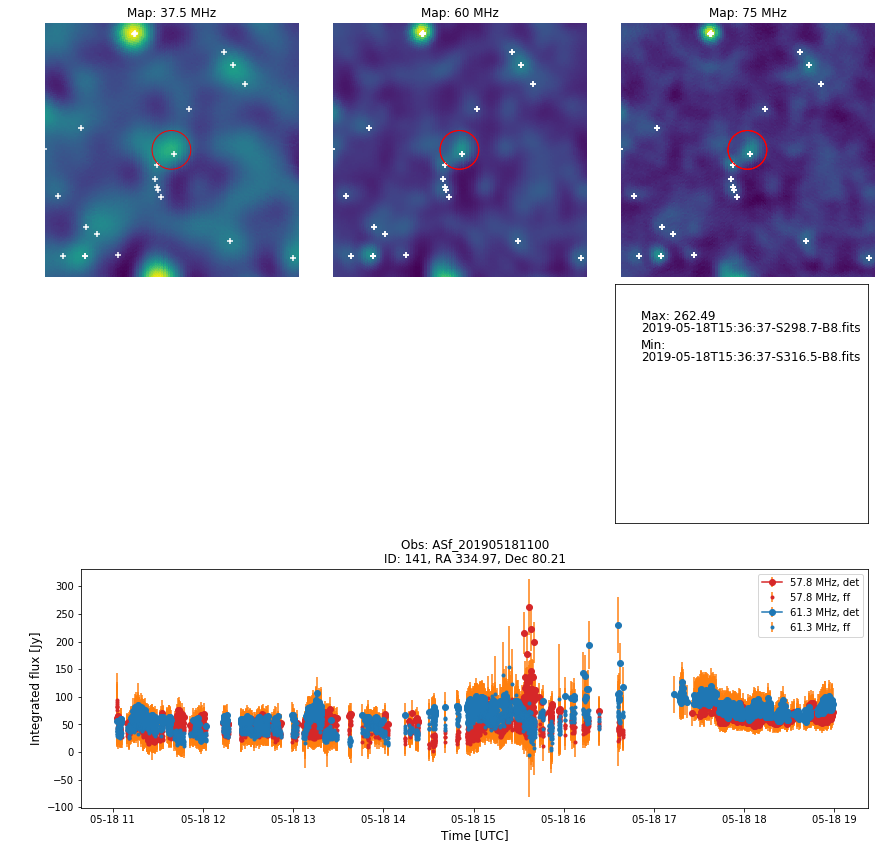

Image files not on disk


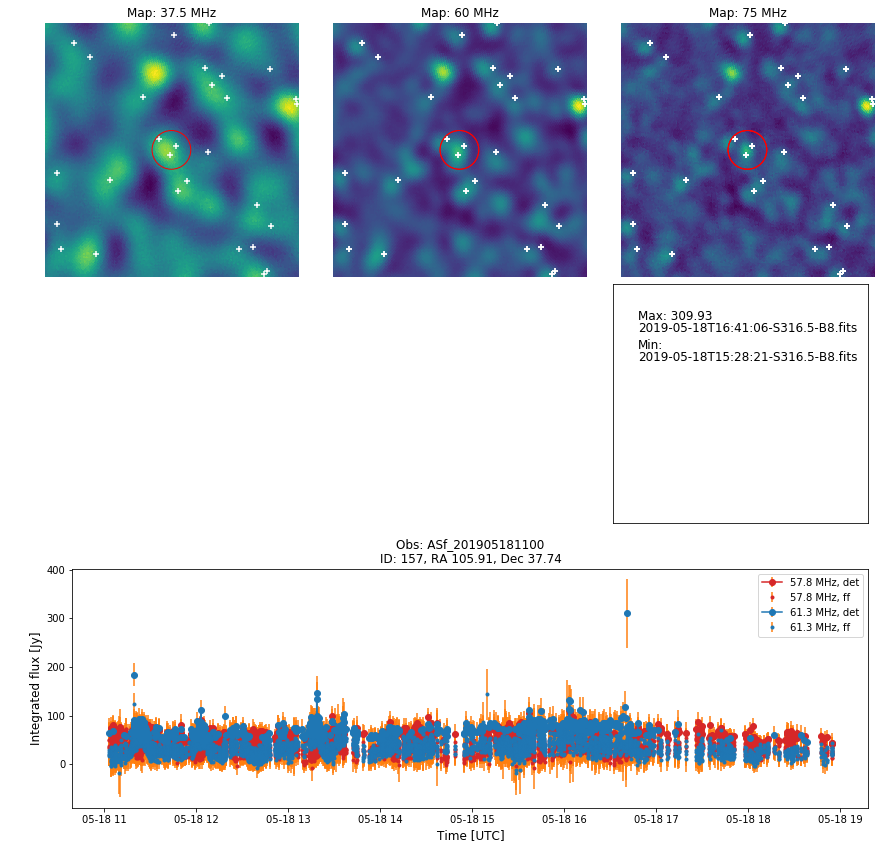

Image files not on disk


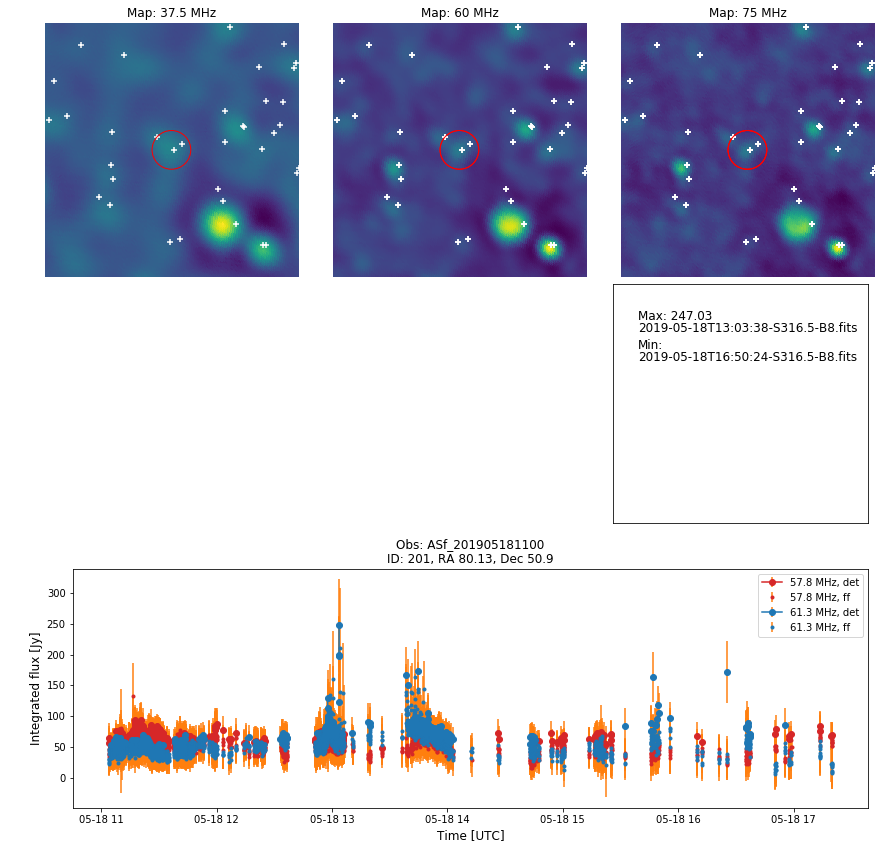

Image files not on disk


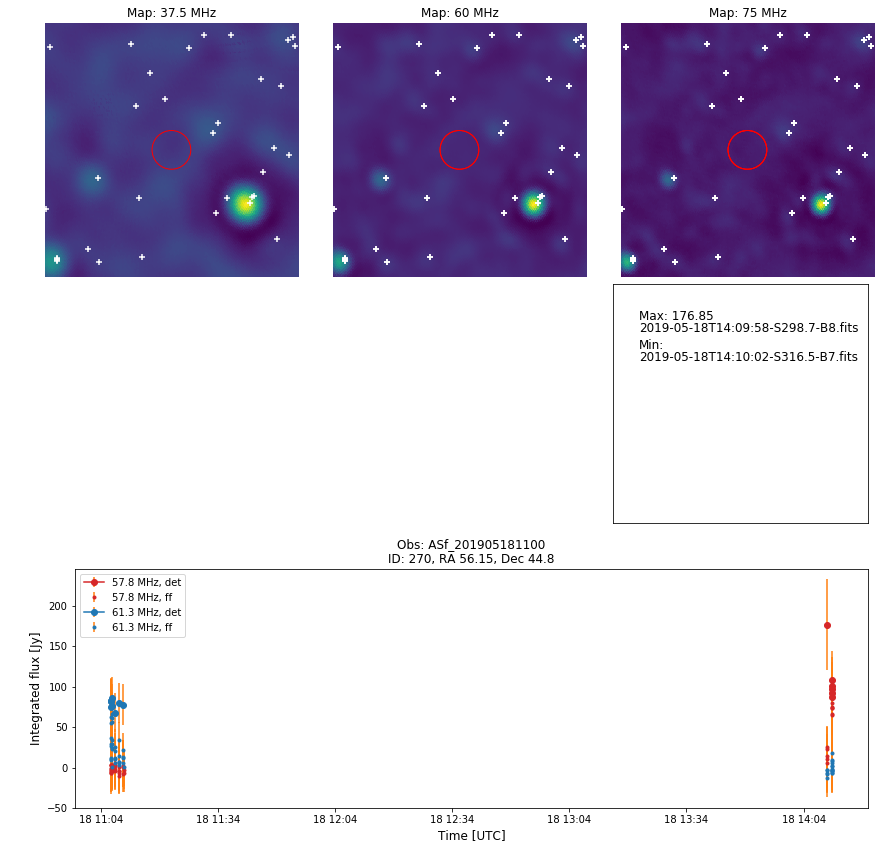

Image files not on disk


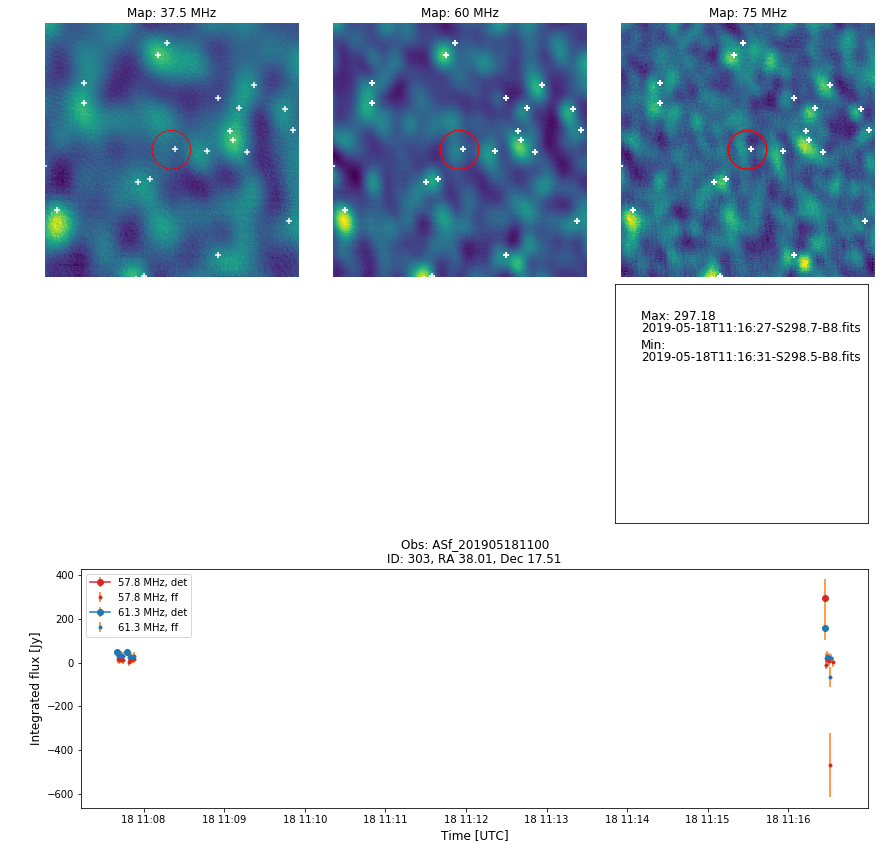

Image files not on disk


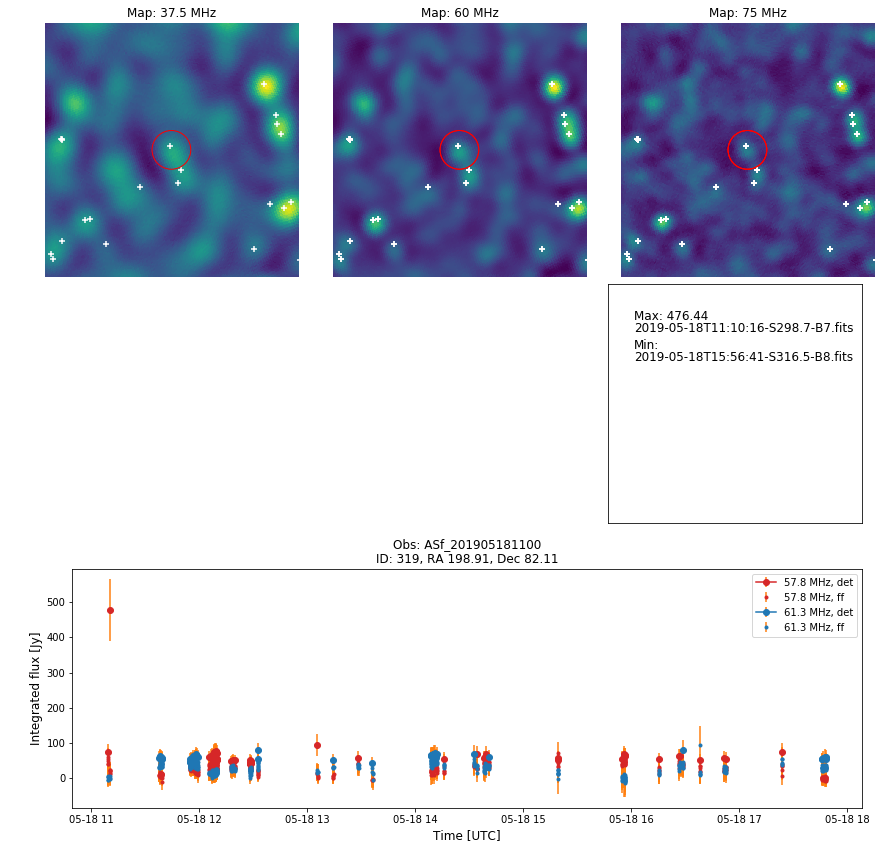

Image files not on disk


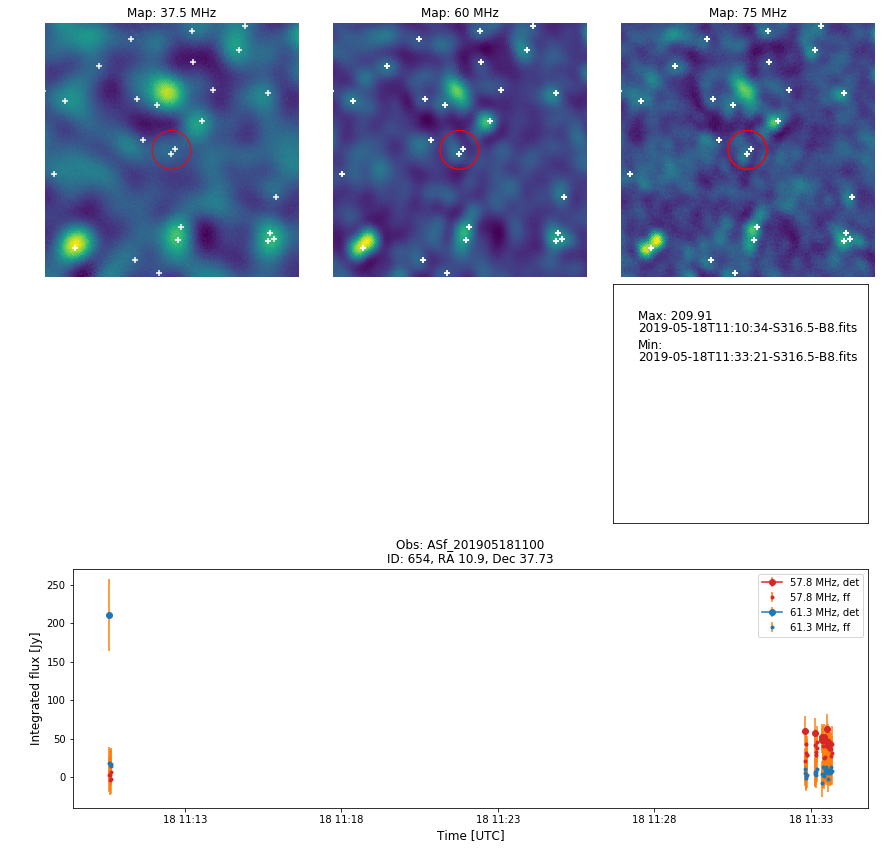

Image files not on disk


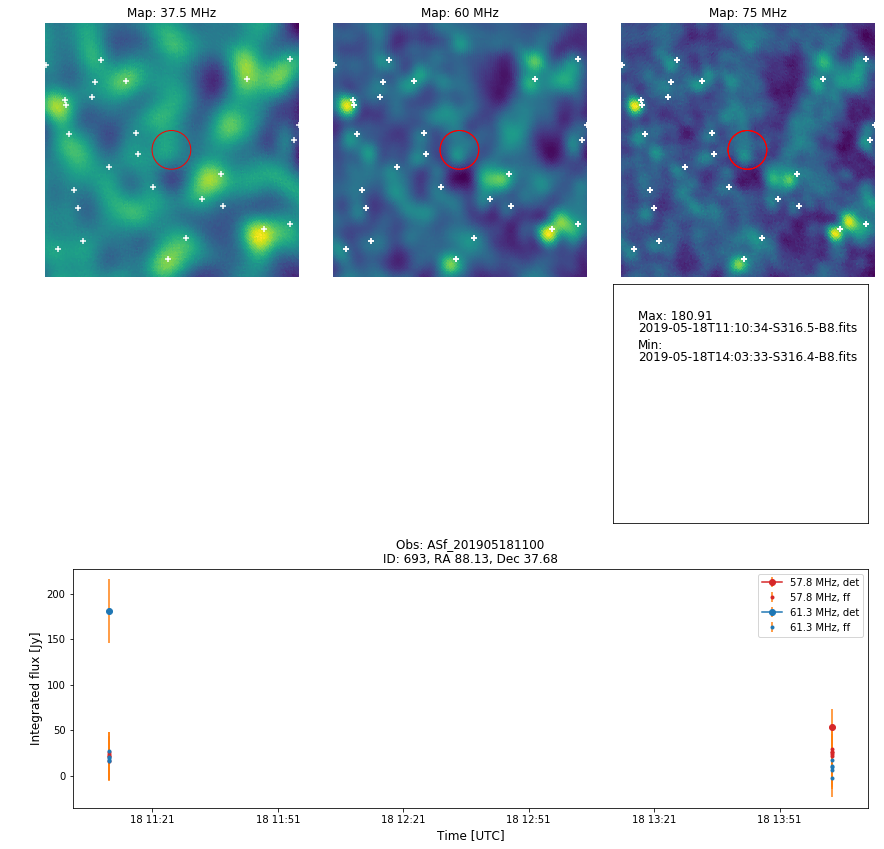

Image files not on disk


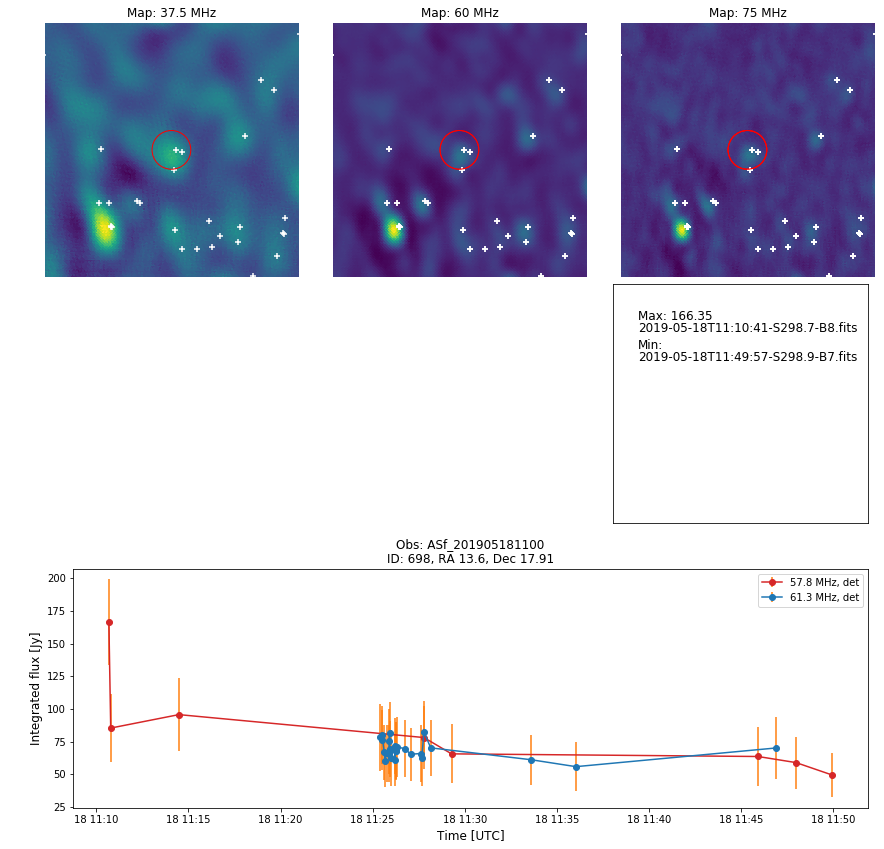

Image files not on disk


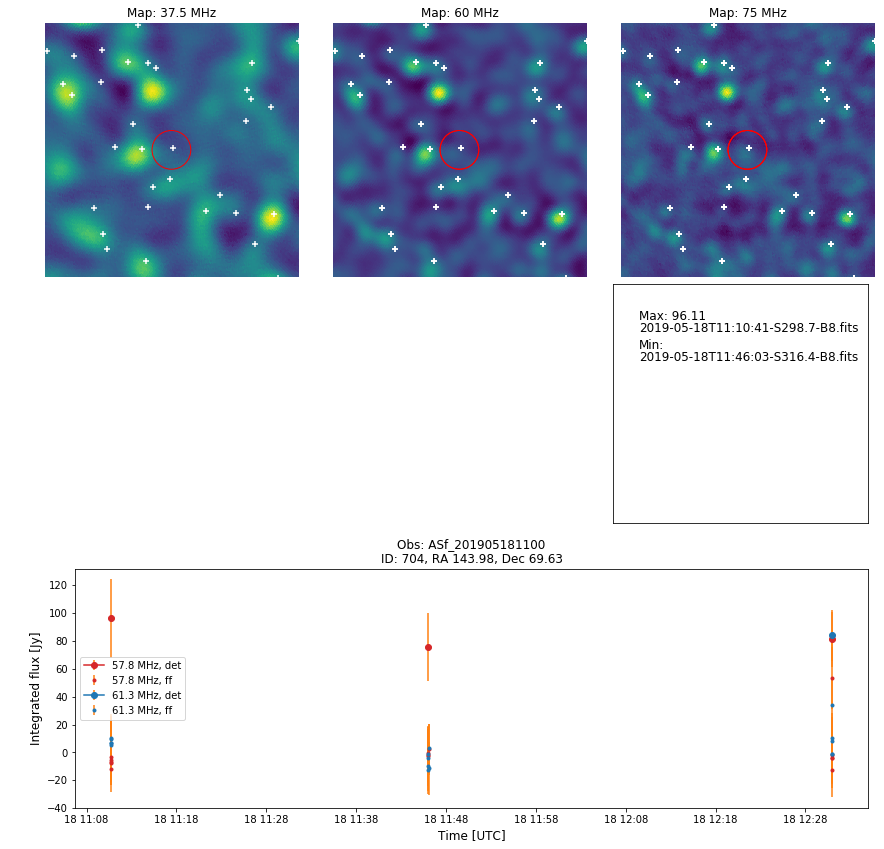

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201905181100
INFO:tkp.db.database:connecting to database...


Run Query: 2019-05-18 11:12:00 2019-05-18 11:22:00 55.766283989
Sigma filter: 12.9967389107
Spacetime filter: 0.917709112167
Image files not on disk


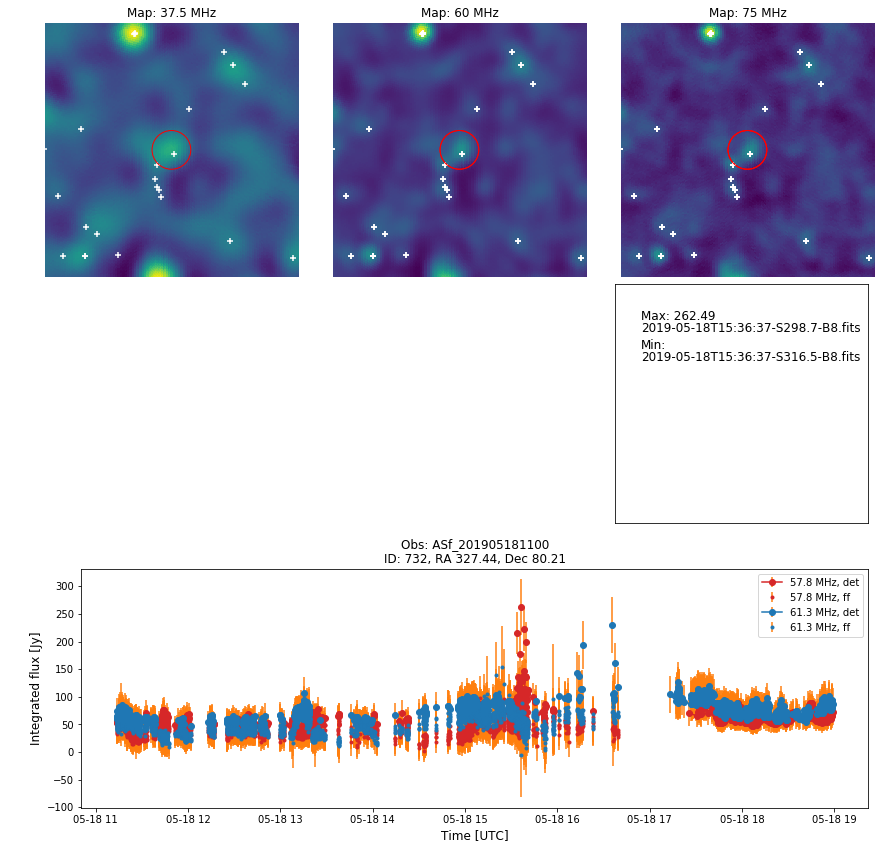

Image files not on disk


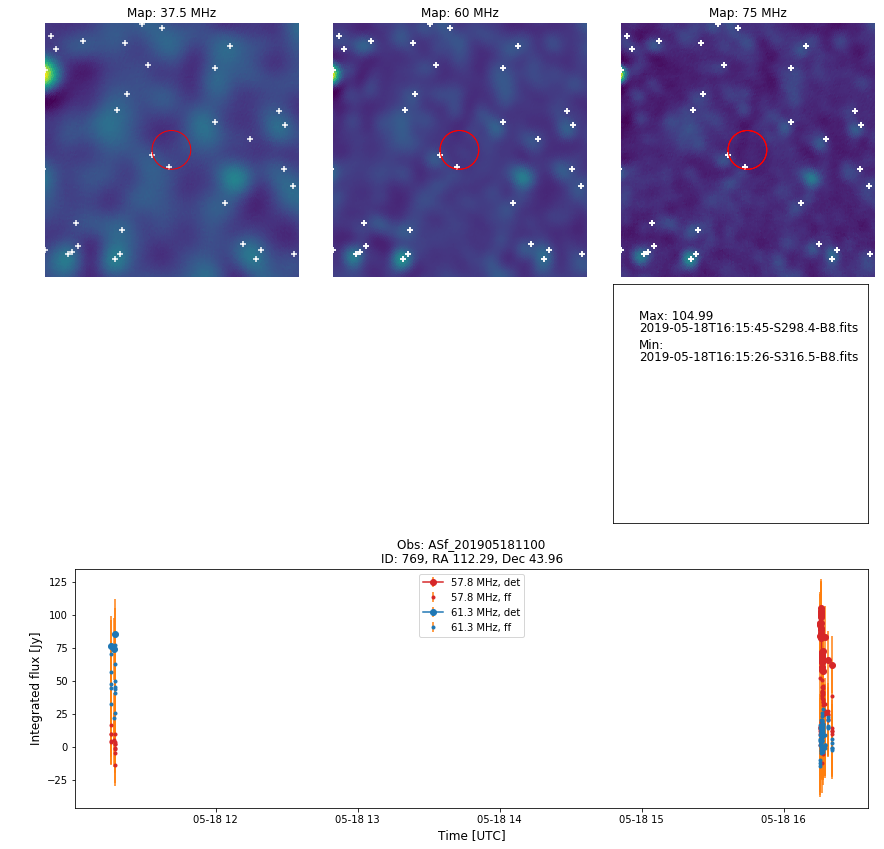

Image files not on disk


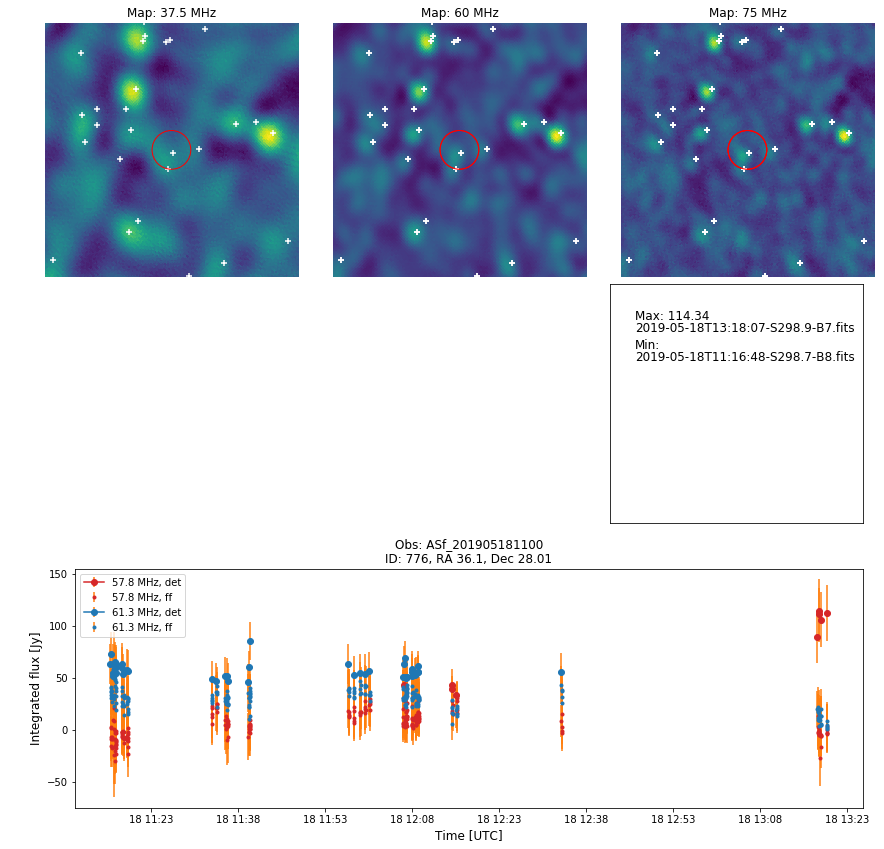

Image files not on disk


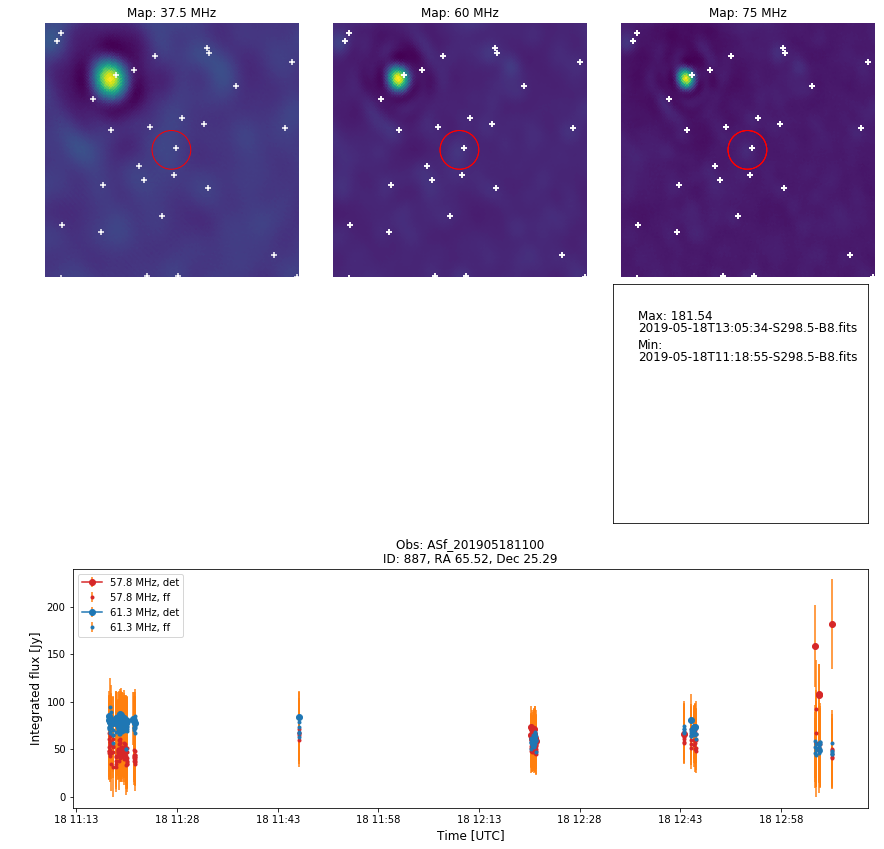

Image files not on disk


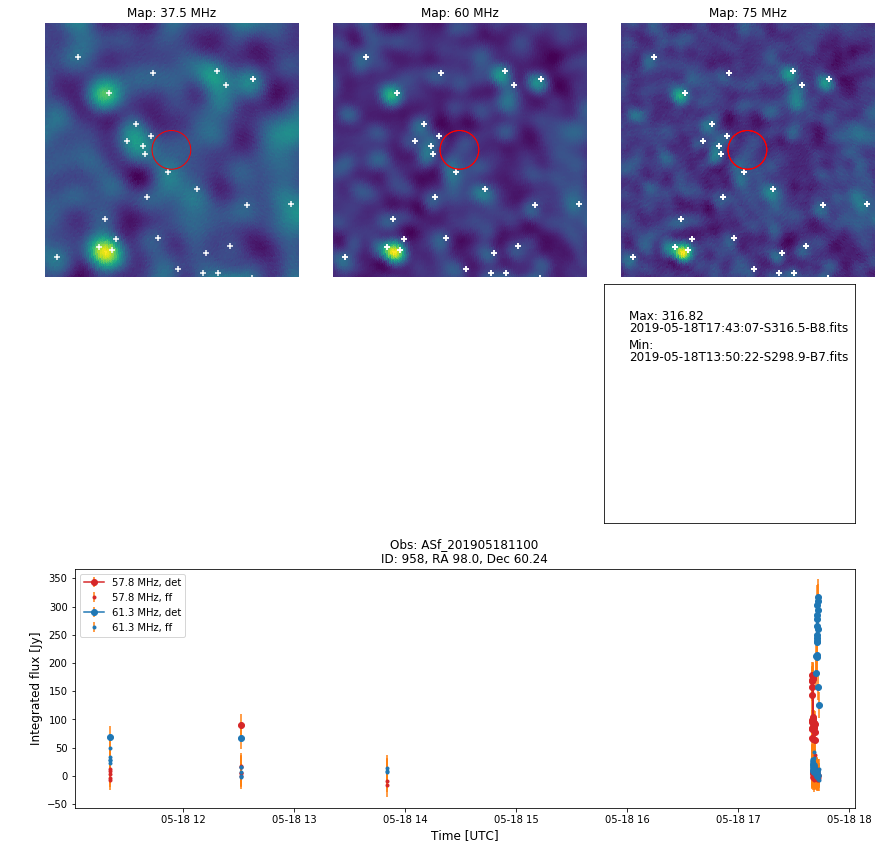

Image files not on disk


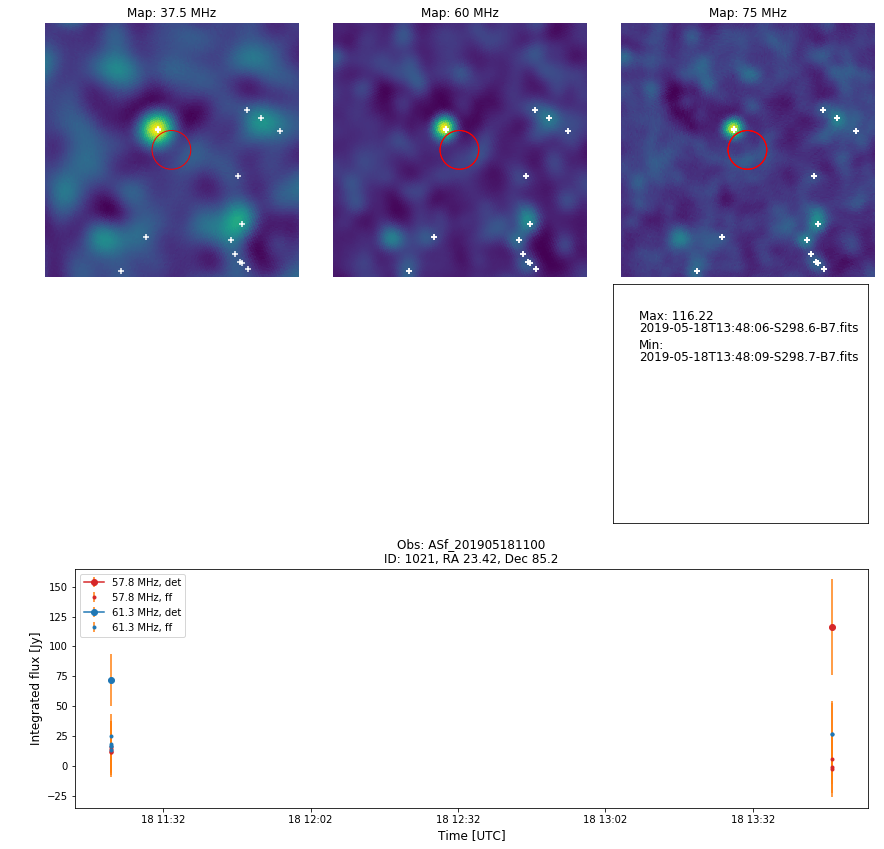

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/ASf_201905181100
INFO:tkp.db.database:connecting to database...


KeyboardInterrupt: 

In [8]:
tot_time = time.time()

vlssr = pd.read_csv("/home/kuiack/VLSSr.tsv", comment="#", delimiter="\t")
# tgss = pd.read_csv("/home/kuiack/TGSSADR1_7sigma_catalog.tsv", delimiter="\t")
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")
ateam = {"ra":np.array([82.88,299.43,350.28,187.07]),
         "decl":np.array([21.98,40.59,58.54,12.66])}


AS_db = "ASf_201905181100"
dataset = 1

logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)


# Catalogue filter items
aart_coord = SkyCoord(aart.ra.values*u.deg, aart.decl.values*u.deg, frame='fk5')
ateam_coord = SkyCoord(ateam["ra"]*u.deg, ateam["decl"]*u.deg, frame='fk5')

# Inspection plot making items
stamp_side = 600
half_side = int(stamp_side/2)

x = np.linspace(0, stamp_side, stamp_side)
y = np.linspace(0, stamp_side, stamp_side)
x, y = np.meshgrid(x, y)

map_dir = "/home/kuiack/skymaps/"
files = glob.glob(map_dir+"*.fits")
BANDS = [os.path.basename(i)[:4] for i in files]

delta = 100 
vlssr_thresh= 5

map_load_1 = hp.fitsfunc.read_map(map_dir+BANDS[2]+"_512_map.fits")
map_load_2 = hp.fitsfunc.read_map(map_dir+BANDS[3]+"_512_map.fits")
map_load_3 = hp.fitsfunc.read_map(map_dir+BANDS[18]+"_512_map.fits")



# get beginning and end time
time_1 = time.time()
db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=AS_db)

db.connect()
session = db.Session()

transients_query = """
    (SELECT taustart_ts 
    FROM image ORDER BY taustart_ts ASC LIMIT 30)
    UNION ALL
    (SELECT taustart_ts 
    FROM image ORDER BY taustart_ts DESC LIMIT 30)
    """

time_range = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                                          engine, host, port, user, password))

db._configured = False
del db, session

time_intervals = pd.date_range(start= np.min(time_range[np.abs(time_range.diff(periods= -10)
                                                               .astype('timedelta64[s]')) < 15.]
                                             .taustart_ts),
                               end= np.max(time_range[np.abs(time_range.diff(periods= -10)
                                                             .astype('timedelta64[s]')) < 15.]
                                           .taustart_ts)+datetime.timedelta(minutes=9),
                               freq="10min")

print "Get time intervals:",  time.time() - time_1

fig_n = 1
for t1, t2 in zip(time_intervals[:-1],time_intervals[1:]):
    time_1 = time.time()
    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()


# Works, but is slow.
    transients_query = """
        SELECT  im.taustart_ts
                ,im.freq_eff
                ,im.band
                ,im.rms_min
                ,im.rms_max
                ,im.url
                ,ex.f_int
                ,ex.f_int_err
                ,ex.f_peak
                ,ex.f_peak_err
                ,ex.ra
                ,ex.decl
                ,ex.ra_err
                ,ex.decl_err
                ,ex.extract_type
                ,ex.det_sigma
                ,ax.runcat as runcatid
                ,ax.v_int
                ,ax.eta_int
                ,ax.f_datapoints
        FROM extractedsource ex
             ,assocxtrsource ax
             ,image im
             ,runningcatalog rc
        WHERE ax.runcat = rc.id 
           AND ax.xtrsrc = ex.id
           AND ex.image = im.id
           AND rc.id IN
        (SELECT DISTINCT ns.runcat 
        FROM image im, newsource ns 
        WHERE ns.trigger_xtrsrc 
        IN (SELECT ex.id 
            FROM extractedsource ex, image im 
            WHERE ex.image = im.id 
            AND im.taustart_ts 
            BETWEEN '{}' AND '{}'))""".format(t1, t2)

    transients = pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                              engine, host, port, user, password))
    
    transients = transients[transients.rms_max < 3e2]
    
    db._configured = False
    del db, session

    print "Run Query:", t1,t2, time.time() - time_1

    # Reduce with conditions requireing simultaneous 5sigma and one 8sigma detection
    time_1 = time.time()

    N_detections = 0 

    reduced = pd.DataFrame([])


    transients["round_times"] = transients.taustart_ts.dt.round("1s")


    for _id in np.unique(transients.runcatid):
        if (np.min(transients[(transients.runcatid == _id) & \
                             (transients.band == 24) & \
                             (transients.extract_type == 0)].round_times) < \
        np.min(transients[(transients.runcatid == _id) & \
                          (transients.band == 23) & \
                          (transients.extract_type == 0)].round_times) \
    #     and (np.max(transients[(transients.runcatid == _id )].det_sigma) > 8 ):
        or

    # for _id in np.unique(transients.runcatid):
        len(transients[(transients.runcatid == _id) & \
                    (transients.band == 23) & \
                    (transients.extract_type == 0)].set_index("round_times").index.\
               intersection(transients[(transients.runcatid == _id) & \
                                 (transients.band == 24) & \
                                 (transients.extract_type == 0)].set_index("round_times").index )) > N_detections) \
        and (np.max(transients[(transients.runcatid == _id )].det_sigma) > 8 ):

            if len(reduced) == 0:
                reduced = pd.DataFrame(transients[(transients.runcatid == _id)])
            else:
                reduced = pd.concat([reduced, transients[(transients.runcatid == _id)]])

    print "Sigma filter:", time.time() - time_1
    
# Make small reference catalogue of candidates
    base = reduced.groupby("runcatid").median()
    base["taustart_ts"] = reduced.groupby("runcatid").first().taustart_ts
    base["timestep"] = [x.timestamp() for x in base.taustart_ts]

# AARTFAAC Catalogue, Ateam, airplane filter 
    time_1 = time.time()


    filtered = pd.DataFrame([], columns=base.keys())
    AART_catsource = pd.DataFrame([], columns=base.keys())


    for i in base.index:
        try:
            c1 = SkyCoord(base.loc[i].ra*u.deg, base.loc[i].decl*u.deg, frame='fk5')

            c2 = SkyCoord(base.drop(index=i).ra.values*u.deg, 
                      base.drop(index=i).decl.values*u.deg, frame='fk5')
        except IndexError:
            print i
        if np.min(c1.separation(ateam_coord).deg) < 10:
            continue 

        elif np.min(c1.separation(aart_coord).deg) < 3 and base.loc[i].f_datapoints.astype(float) > 10:
            if len(AART_catsource) == 0:
                AART_catsource = pd.DataFrame(base.loc[i]).T
            else:
                AART_catsource = pd.concat([AART_catsource, pd.DataFrame(base.loc[i]).T])


        elif np.logical_or(((c1.separation(c2).deg) > 5),
                           (np.abs(base.loc[i].timestep - base.drop(index=i).timestep) > 500)).all():
            if len(filtered) == 0:
                filtered = pd.DataFrame(base.loc[i]).T
            else:
                filtered = pd.concat([filtered, pd.DataFrame(base.loc[i]).T])

    print "Spacetime filter:", time.time() - time_1


# Make inspection plot
    
    dbname = AS_db
    ObsDir = "/mnt/ads001/"+dbname+"_Candidates/"



    for _ID in filtered.index: #AART_catsource.index:

        source_df = retrieve_source(transients, _ID)

        _source_flux = source_df.f_int[(source_df.freq_eff < 60000000) ].values
        _index = source_df.extract_type[(source_df.freq_eff < 60000000) ].values
        _source_flux[(_index == 1)] = np.nan


        plt.figure(fig_n, figsize=(12,12))

        stamp = hp.gnomview(map_load_1,  xsize=stamp_side,
                            rot=([base.loc[_ID].ra,
                                  base.loc[_ID].decl]),
                            coord="C", return_projected_map=True,fig=fig_n,sub=333,notext=True, title="Map: 75 MHz",cbar=False)

        hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                    vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                       marker="+", color="white", coord="C")

        hp.projscatter(base.loc[_ID].ra,
                       base.loc[_ID].decl,lonlat=True,
                       edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)
    #######
        stamp = hp.gnomview(map_load_3,  xsize=stamp_side,
                            rot=([base.loc[_ID].ra,
                                  base.loc[_ID].decl]),
                            coord="C", return_projected_map=True, 
                            fig=fig_n,sub=332, notext=True, title="Map: 60 MHz", cbar=False)

        hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                    vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                       marker="+", color="white", coord="C")

        hp.projscatter(base.loc[_ID].ra,
                       base.loc[_ID].decl,lonlat=True,
                       edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)

    ########
        stamp = hp.gnomview(map_load_2, xsize=stamp_side,
                            rot=([base.loc[_ID].ra,
                                  base.loc[_ID].decl]),
                            coord="C", return_projected_map=True, fig=1,sub=331, notext=True, title="Map: 37.5 MHz",cbar=False)


        hp.projscatter(vlssr[vlssr.Sp > vlssr_thresh]._RAJ2000.values,
                    vlssr[vlssr.Sp > vlssr_thresh]._DEJ2000.values, lonlat=True,
                       marker="+", color="white", coord="C")

        hp.projscatter(base.loc[_ID].ra,
                       base.loc[_ID].decl,lonlat=True,
                       edgecolors="red", facecolor="none", s=1500, coord="C", lw=1)

        plt.subplot(313)

        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000)].values,
                     _source_flux, 
                     yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) ].values,
                     fmt="o-", color="C3",ecolor="C1", label="57.8 MHz, det")

        del _source_flux

        if len(source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values) > 0:
            plt.errorbar(source_df.taustart_ts[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                         source_df.f_int[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values, 
                         yerr = source_df.f_int_err[(source_df.freq_eff < 60000000) & (source_df.extract_type == 1 )].values,
                         fmt=".", color="C3",ecolor="C1", label="57.8 MHz, ff")


        _source_flux = source_df.f_int[(source_df.freq_eff > 60000000) ].values
        _index = source_df.extract_type[(source_df.freq_eff > 60000000) ].values
        _source_flux[(_index == 1)] = np.nan


        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) ].values,
                     _source_flux, 
                     yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) ].values,
                     fmt="o-",color="C0", ecolor="C1", label="61.3 MHz, det")

        del _source_flux

        if len(source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values) > 0:
            plt.errorbar(source_df.taustart_ts[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                         source_df.f_int[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values, 
                         yerr = source_df.f_int_err[(source_df.freq_eff > 60000000) & (source_df.extract_type == 1 )].values,
                         fmt=".", color="C0",ecolor="C1", label="61.3 MHz, ff")


        plt.legend()
        if dbname[:3] == "ASr":
            plt.ylabel("Integrated flux [arbitrary]")
        elif dbname[:3] == "ASf":
            plt.ylabel("Integrated flux [Jy]")
        plt.xlabel("Time [UTC]")

        plt.title("Obs: "+dbname+"\nID: "+str(_ID)+", RA "+str(round(source_df.ra.mean(),2))+", Dec "+str(round(source_df.decl.mean(),2)))

        # if images are on disk make image stamps 
        try:
            if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.max()].url[0]):
                filename = source_df[ source_df.f_int == source_df.f_int.max()].url[0]
            else: 
                filename = "/mnt/ais001/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[2]+"/"+source_df[ source_df.f_int == source_df.f_int.max()].url[0].split("/")[3]


            wcs = WCS(filename)
            im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

            pos = [im_pix_x, im_pix_y]
            plt.subplot(3,3,4)
            plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
            plt.text(0.5,0.5,"max", color="white", fontsize=18)
            plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
            plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")

            plt.xticks([])
            plt.yticks([])

            plt.subplot(3,3,5)
            if  os.path.isfile(source_df[ source_df.f_int == source_df.f_int.min()].url[0]):
                filename = source_df[ source_df.f_int == source_df.f_int.min()].url[0]

            wcs = WCS(filename)
            im_pix_x, im_pix_y, n, nn = wcs.wcs_world2pix(source_df.ra.mean(),source_df.decl.mean(),1,1,1)

            pos = [im_pix_x, im_pix_y]

            plt.text(5,92,os.path.basename(filename), color="white", fontsize=12)
            plt.text(0.5,0.5,"min", color="white", fontsize=18)
            plt.imshow(fits.open(filename)[0].data[0,0,pos[1]-delta/2:pos[1]+delta/2,pos[0]-delta/2:pos[0]+delta/2], origin="lower")
            plt.scatter(delta/2,delta/2, s=50*delta, facecolor="none", edgecolor="red")
            plt.xticks([])
            plt.yticks([])
            
            
        except TypeError:
            print "Image files not on disk"


        ax = plt.subplot(3,3,6)
        plt.text(0.1,0.85,"Max: {}".format(round(source_df[ source_df.f_int == source_df.f_int.max()].f_int.values[0],2)), 
                 color="black",transform=ax.transAxes,fontsize=12)

        plt.text(0.1, 0.80, os.path.basename(source_df[ source_df.f_int == source_df.f_int.max()].url[0]), 
                 color="black",transform=ax.transAxes, fontsize=12)

        plt.text(0.1, 0.68, os.path.basename(source_df[ source_df.f_int == source_df.f_int.min()].url[0]), 
                 color="black",transform=ax.transAxes, fontsize=12)
        plt.text(0.1,0.73,"Min:", color="black",transform=ax.transAxes,fontsize=12)
        plt.plot()
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        
        fig_n +=1
        if not os.path.exists(ObsDir):
            os.makedirs(ObsDir)
        
        if not os.path.exists(ObsDir+"CandidatePandas"):
            os.makedirs(ObsDir+"CandidatePandas")

#         for _ID in filtered.index:
        source_df = retrieve_source(transients, _ID)
        plt.savefig(ObsDir+str(_ID)+"_lightcurve.png")
        source_df.to_csv(ObsDir+"/CandidatePandas/"+str(_ID)+"-source_df.csv", index=False)
        
        plt.show()
print "Total time:", time.time() - tot_time

In [45]:
print ObsDir+"CandidatePandas/"+str(_ID)+"-source_df.csv"

/mnt/ads001/ASr_201609051647_Candidates/CandidatePandas/43-source_df.csv


In [46]:
os.path.exists(ObsDir)

True

In [47]:
ObsDir

'/mnt/ads001/ASr_201609051647_Candidates/'